## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [ ]:
# import functools
# import string
# import os
from turtledemo.paint import switchupdown

# from week0_08_dropout_batchnorm.practice_pytorch_and_dataloaders import optimizer
#
# from homeworks.assignment0_05_nn_from_scratch.assignment0_05_submission_template import batch_size

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [ ]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [ ]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

### Data loading: "Евгений Онегин"


In [2]:
# !wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()
    
text = [x.replace('\t\t', '') for x in text]

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [3]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
import re

roman_pattern = re.compile(r'^[IVXLCDMivxlcdm]+\s*$')

text = ''.join(
    line.replace('\t', '').replace('\n', '')
    for line in text
    if not roman_pattern.match(line.strip())
).lower()


Put all the characters, that you've seen in the text, into variable `tokens`.

In [4]:
tokens = sorted(set(text))
tokens

[' ',
 '!',
 '(',
 ')',
 ',',
 '-',
 '.',
 '5',
 '7',
 '8',
 '9',
 ':',
 ';',
 '?',
 '[',
 ']',
 '^',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '«',
 '»',
 'а',
 'б',
 'в',
 'г',
 'д',
 'е',
 'ж',
 'з',
 'и',
 'й',
 'к',
 'л',
 'м',
 'н',
 'о',
 'п',
 'р',
 'с',
 'т',
 'у',
 'ф',
 'х',
 'ц',
 'ч',
 'ш',
 'щ',
 'ъ',
 'ы',
 'ь',
 'э',
 'ю',
 'я',
 'ё',
 '–',
 '—',
 '’',
 '…',
 '€']

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [5]:
# dict <index>:<char>
# Your great code here
token_to_idx = {token: idx for idx, token in enumerate(tokens)}

# dict <char>:<index>
# Your great code here
idx_to_token = {idx: token for idx, token in enumerate(tokens)}

In [6]:
vocab_size = len(tokens)
vocab_size

82

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [7]:
# Your code here
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
encoded = torch.tensor([token_to_idx[ch] for ch in text])
print('encoded shape:', encoded.shape, 'vocab_size:', vocab_size)

encoded shape: torch.Size([133529]) vocab_size: 82


In [9]:
from torch.utils.data import Dataset, DataLoader

class CharDataset(Dataset):
    def __init__(self, data, seq_len: int):
        self.data = data
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        x = self.data[idx: idx + self.seq_len]
        y = self.data[idx + 1: idx + 1 + self.seq_len]
        return x, y

In [10]:
seq_len = 100
dataset = CharDataset(encoded, seq_len)
batch_size = 64
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [11]:
class CharRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_size=256, num_layers=1):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.RNN(
            input_size=embed_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            nonlinearity='tanh'
        )
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, h0=None):
        x = self.embed(x)
        out, h = self.rnn(x, h0)
        logits = self.fc(out)
        return logits, h

In [12]:
model_rnn = CharRNN(vocab_size=vocab_size, embed_dim=128, hidden_size=256, num_layers=1).to(device)
optimizer = torch.optim.Adam(model_rnn.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [13]:
def train_model(model, loader, optimizer, criterion, device, num_epochs=20):
    model.train()
    epoch_losses = []

    for epoch in range(1, num_epochs + 1):
        running_loss = 0.0
        total_tokens = 0

        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)

            optimizer.zero_grad()

            logits, _ = model(xb)

            logits = logits.reshape(-1, model.vocab_size)
            targets = yb.reshape(-1)

            loss = criterion(logits, targets)
            loss.backward()
            optimizer.step()

            batch_tokens = targets.numel()
            running_loss += loss.item() * batch_tokens
            total_tokens += batch_tokens


        epoch_loss = running_loss / total_tokens
        epoch_losses.append(epoch_loss)
        print(f'Epoch {epoch: 02d} | train_loss = {epoch_loss: .4f}')

    return epoch_losses

In [14]:
def plot_loss(epoch_losses, title="Training loss"):
    epochs = range(1, len(epoch_losses) + 1)
    plt.figure(figsize=(6, 4))
    plt.plot(epochs, epoch_losses, marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.grid(True)
    plt.show()

Plot the loss function (axis X: number of epochs, axis Y: loss function).

Epoch  1 | train_loss =  1.9008
Epoch  2 | train_loss =  1.4166
Epoch  3 | train_loss =  1.2829
Epoch  4 | train_loss =  1.2399
Epoch  5 | train_loss =  1.2199
Epoch  6 | train_loss =  1.2087
Epoch  7 | train_loss =  1.2007
Epoch  8 | train_loss =  1.1948
Epoch  9 | train_loss =  1.1894
Epoch  10 | train_loss =  1.1855
Epoch  11 | train_loss =  1.1815
Epoch  12 | train_loss =  1.1784
Epoch  13 | train_loss =  1.1757
Epoch  14 | train_loss =  1.1731
Epoch  15 | train_loss =  1.1705
Epoch  16 | train_loss =  1.1681
Epoch  17 | train_loss =  1.1660
Epoch  18 | train_loss =  1.1640
Epoch  19 | train_loss =  1.1624
Epoch  20 | train_loss =  1.1602


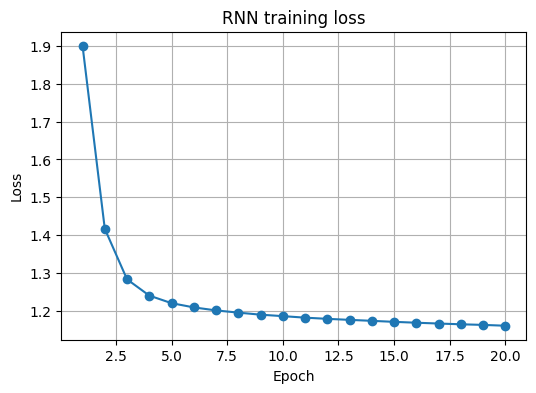

In [15]:
# Your plot code here
num_epochs = 20
losses_rnn = train_model(model_rnn, loader, optimizer, criterion, device, num_epochs=num_epochs)
plot_loss(losses_rnn, title="RNN training loss")

In [16]:
def generate_text(model, start_text, length=300, temperature = 1.0):
    model.eval()

    input_indices = [token_to_idx[ch] for ch in start_text]
    input_tensor = torch.tensor(input_indices, dtype=torch.long, device=device).unsqueeze(0)

    generated = list(start_text)
    hidden = None

    with torch.no_grad():
        logits, hidden = model(input_tensor, hidden)

        last_idx = input_tensor[0, -1].unsqueeze(0).unsqueeze(0)

        for _ in range(length):
            logits, hidden = model(last_idx, hidden)
            logits = logits[:, -1, :] / temperature
            probs = F.softmax(logits, dim=-1)

            next_idx = torch.multinomial(probs, num_samples=1)
            idx = next_idx.item()
            generated.append(idx_to_token[idx])

            last_idx = next_idx

    return ''.join(generated)

In [17]:
start = "самых честных правил".lower()
print(generate_text(model_rnn, start_text=start, length=400, temperature=0.5))

самых честных правилес не ему послушна,творгулать?» – «а досуг.уже встречаеть должно ль раннуть ей медведь прости.онегин верной скоре было в волненье умол.и снег. —ель любовь и вот по мазуредной,нет то жранным одна,и бьют был приятный вздор;за ней, как жентаним, он приятный ждоровь, нежней пересет рассегер и верно и сток поляться возможной тани мало крыльцарик глубоко дома ждет отпищать».неда, попрамона нетерно по сл


In [18]:
# An example of generated text.
# print(generate_text(length=500, temperature=0.2))

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [19]:
# Your beautiful code here
class CharLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_size=256, num_layers=1):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
        )
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, h0=None):
        x = self.embed(x)
        out, h = self.lstm(x, h0)
        logits = self.fc(out)
        return logits, h

In [20]:
model_lstm = CharLSTM(vocab_size=vocab_size, embed_dim=128, hidden_size=256, num_layers=1).to(device)
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [21]:
num_epochs = 20
losses_lstm = train_model(model_lstm, loader, optimizer, criterion, device, num_epochs=num_epochs)

Epoch  1 | train_loss =  1.9297
Epoch  2 | train_loss =  1.1995
Epoch  3 | train_loss =  0.8219
Epoch  4 | train_loss =  0.6421
Epoch  5 | train_loss =  0.5456
Epoch  6 | train_loss =  0.4870
Epoch  7 | train_loss =  0.4490
Epoch  8 | train_loss =  0.4218
Epoch  9 | train_loss =  0.4020
Epoch  10 | train_loss =  0.3868
Epoch  11 | train_loss =  0.3745
Epoch  12 | train_loss =  0.3642
Epoch  13 | train_loss =  0.3555
Epoch  14 | train_loss =  0.3478
Epoch  15 | train_loss =  0.3411
Epoch  16 | train_loss =  0.3354
Epoch  17 | train_loss =  0.3301
Epoch  18 | train_loss =  0.3253
Epoch  19 | train_loss =  0.3210
Epoch  20 | train_loss =  0.3168


In [22]:
def plot_two_losses(losses_rnn, losses_lstm, label_rnn="RNN", label_lstm="LSTM", title="Training loss"):
    epochs_rnn = range(1, len(losses_rnn) + 1)
    epochs_lstm = range(1, len(losses_lstm) + 1)

    plt.figure(figsize=(7, 4))
    plt.plot(epochs_rnn, losses_rnn, marker='o', label=label_rnn)
    plt.plot(epochs_lstm, losses_lstm, marker='o', label=label_lstm)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

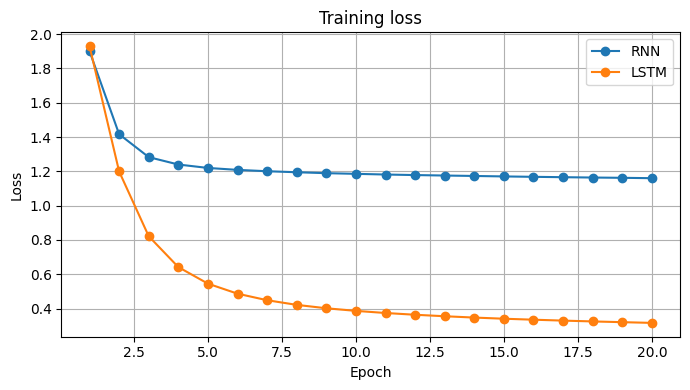

In [23]:
plot_two_losses(losses_rnn, losses_lstm)

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [27]:
# Text generation with different temperature values here
start = "мой дядя самых честных правил".lower()
temp_list = [0.1, 0.2, 0.5, 1.0, 2.0]
for temp in temp_list:
    print(f'{generate_text(model_lstm, start_text=start, length=400, temperature=temp)}\n')

мой дядя самых честных правилась;кому пере своей томных весно;он постелю свои тайной,румян, как вербный хладнокровно…не засмеяться ль им, покане облаженный,слова у ольги ободренный,ромучая зеркала с досадой,в придет иль не заметил;ред сей ничего евгений.он в полночно для поэта:без вновь по краткомносоюи пьет одностаканапраще не присуж писал;что в в моей лишь было власти,я предпочла б обидной страсти и планул моя?»– ты, какие 

мой дядя самых честных правилась;кому пере своей томный взор.вдруг топот!.. кровь ее застыла.вот ближе! скачут… и на дворевгений! «ах!» – и легче тенитатьяна прыг в другие сени,с крыльца на двор, и прямо в сады,любви привела удалая;я тут ничего на являть голова,кто бы послушает к ольге ветви всеклокаромуны надежды темныйв форей,элегкие рокавый клафы старого взоризобратился в облегкой в меныхотрыдав, чем лунав глядел: «рас, пи

мой дядя самых честных правилась,в обморок упам,и полно глубокови чисто: вот семен речит: и отстала,да нежный дрову горды,молоком он голов

### Анализ результата
При низкой температуре (0.1-0.2) текст получается очень похожим на обучающие данные: он относительно грамматичный, но мало разнообразный и местами почти копирует корпус. При средней температуре (~0.5) появляется хороший баланс - текст становится более “творческим”, но еще сохраняет читаемость и стиль. При высоких значениях (1.0–2.0) растет случайность: увеличивается число несуществующих слов и ошибок, и текст превращается в почти бессмысленный набор слогов.

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [25]:
from pathlib import Path

def save_checkpoint(model, filename, token_to_idx: dict, idx_to_token: dict, *, embed_dim: int, hidden_size: int, num_layers: int):
    checkpoint = {
        "model_state_dict": model.state_dict(),
        "vocab_size": model.vocab_size,
        "embed_dim": embed_dim,
        "hidden_size": hidden_size,
        "num_layers": num_layers,
        "token_to_idx": token_to_idx,
        "idx_to_token": idx_to_token,
    }
    checkpoint_path = Path.cwd() / filename
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint saved to: {checkpoint_path}")

In [26]:
def load_checkpoint(checkpoint_path: str, model_class, device: str = None):

    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    checkpoint = torch.load(checkpoint_path, map_location=device)

    vocab_size = checkpoint["vocab_size"]
    embed_dim = checkpoint["embed_dim"]
    hidden_size = checkpoint["hidden_size"]
    num_layers = checkpoint["num_layers"]

    token_to_idx = checkpoint["token_to_idx"]
    idx_to_token = checkpoint["idx_to_token"]

    model = model_class(
        vocab_size=vocab_size,
        embed_dim=embed_dim,
        hidden_size=hidden_size,
        num_layers=num_layers,
    ).to(device)

    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()

    print(f"Checkpoint loaded from: {checkpoint_path}")
    return model, token_to_idx, idx_to_token

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)